In [40]:
# ===================================================================
# FDA FAERS 2025Q1 Adverse Event Data Quality Analysis
# ===================================================================
# Source: FDA FAERS Database, Quarter 1 2025 (Jan-Mar 2025)
# Analysis Date: 06/04/2025
# Analyst: Micheal Beatty

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [41]:
# ===================================================================
# 1. DATA LOADING AND SETUP
# ===================================================================

# Load FAERS 2025Q1 demographic data
demo_df = pd.read_csv('data/DEMO25Q1.txt', delimiter='$', encoding='latin-1', low_memory=False)

# Standardize manufacturer names immediately after loading
demo_df['mfr_sndr'] = demo_df['mfr_sndr'].str.upper().str.strip()

# Then define missing subsets
all_missing_demo = demo_df[demo_df[['age', 'sex', 'wt']].isnull().all(axis=1)]

print(f"FDA FAERS 2025Q1 Dataset Loaded")
print(f"Total Records: {len(demo_df):,}")
print(f"Data Period: January 1 - March 31, 2025")

FDA FAERS 2025Q1 Dataset Loaded
Total Records: 400,514
Data Period: January 1 - March 31, 2025


In [42]:
# ===================================================================
# 2. MISSING DEMOGRAPHICS ANALYSIS
# ===================================================================

# Analyze missing data patterns across critical demographic fields
total_rows = len(demo_df)
demo_cols = ['age', 'age_cod', 'age_grp', 'sex', 'wt', 'wt_cod']

missing_summary = demo_df[demo_cols].isnull().sum().to_frame(name='Missing Count')
missing_summary['Percent Missing'] = (missing_summary['Missing Count'] / total_rows * 100).round(1)
missing_summary = missing_summary.sort_values('Percent Missing', ascending=False)

print("\n=== MISSING DATA ANALYSIS ===")
print(missing_summary.to_string())


# Define records missing ALL critical demographics
all_missing_demo = demo_df[
    demo_df[['age', 'sex', 'wt']].isnull().all(axis=1)
]


print(f"\n=== KEY FINDING ===")
print(f"Records missing ALL demographics (sex, age_grp, weight): {len(all_missing_demo):,}")
print(f"Percentage of total dataset: {len(all_missing_demo)/total_rows*100:.1f}%")

partial_missing_demo = demo_df[
    demo_df[['age', 'sex', 'wt']].isnull().any(axis=1)
]

print(f"Records missing AT LEAST ONE of (age, sex, weight): {len(partial_missing_demo):,} ({len(partial_missing_demo)/total_rows*100:.1f}%)")

# Top 20 manufacturers by report count
top20_mfrs = demo_df['mfr_sndr'].value_counts().head(20)

# Get missing counts just for those 20
missing_by_top20 = all_missing_demo['mfr_sndr'].value_counts().reindex(top20_mfrs.index).fillna(0).astype(int)

# Build clean DataFrame
summary_df = pd.DataFrame({
    'Total Reports': top20_mfrs,
    'Missing All Demographics': missing_by_top20
})
summary_df['Percent Missing'] = (summary_df['Missing All Demographics'] / summary_df['Total Reports'] * 100).round(2)

# Optional: sort by missing percent
summary_df = summary_df.sort_values(by='Percent Missing', ascending=False)

print("\n=== TOP 20 MANUFACTURERS BY VOLUME: MISSINGNESS SUMMARY ===")
print(summary_df.to_string())




=== MISSING DATA ANALYSIS ===
         Missing Count  Percent Missing
wt              331751             82.8
wt_cod          331752             82.8
age_grp         259903             64.9
age             156970             39.2
age_cod         156950             39.2
sex              81778             20.4

=== KEY FINDING ===
Records missing ALL demographics (sex, age_grp, weight): 69,679
Percentage of total dataset: 17.4%
Records missing AT LEAST ONE of (age, sex, weight): 344,637 (86.0%)

=== TOP 20 MANUFACTURERS BY VOLUME: MISSINGNESS SUMMARY ===
                              Total Reports  Missing All Demographics  Percent Missing
mfr_sndr                                                                              
ALEXION PHARMACEUTICALS               12324                      7148            58.00
GLAXOSMITHKLINE                        6340                      2714            42.81
JOHNSON AND JOHNSON                   13302                      2940            22.10
AMGEN

In [43]:
# ===================================================================
# 3. DATA QUALITY ISSUES DISCOVERED
# ===================================================================

print("\n=== DATA QUALITY ISSUES ===")

# Date validation - impossible dates
event_dates = pd.to_datetime(demo_df['event_dt'], format='%Y%m%d', errors='coerce')
future_dates = event_dates > pd.Timestamp.now()
ancient_dates = event_dates < pd.Timestamp('1950-01-01')

print(f"Events in the future: {future_dates.sum()}")
print(f"Events before 1950: {ancient_dates.sum()}")
print(f"Date range: {demo_df['event_dt'].min()} to {demo_df['event_dt'].max()}")
print(f"Spanning {2444-1025} years (1025 AD to 2444 AD)")

# Weight validation - impossible weights
extreme_weights = demo_df[(demo_df['wt'] > 227) & (demo_df['wt_cod'] == 'KG')]
print(f"\nPatients over 227kg (500lbs): {len(extreme_weights)}")
print(f"Maximum weight: {demo_df['wt'].max()} kg ({demo_df['wt'].max() * 2.2:.0f} lbs)")

# Example: The impossible case
baby_elephant = demo_df[(demo_df['age'] == 19) & (demo_df['age_cod'] == 'DY') & (demo_df['wt'] == 3912)]
if not baby_elephant.empty:
    print(f"Found: 19-day-old baby weighing 3,912 kg (8,606 lbs)")

# Report code validation
invalid_rpt_codes = demo_df['rept_cod'].isin(['5DAY', '30DAY']).sum()
print(f"\nInvalid report codes (timeline instead of type): {invalid_rpt_codes:,} ({invalid_rpt_codes/total_rows*100:.1f}%)")



=== DATA QUALITY ISSUES ===
Events in the future: 6
Events before 1950: 4
Date range: 10250101.0 to 24441101.0
Spanning 1419 years (1025 AD to 2444 AD)

Patients over 227kg (500lbs): 59
Maximum weight: 3912.0 kg (8606 lbs)
Found: 19-day-old baby weighing 3,912 kg (8,606 lbs)

Invalid report codes (timeline instead of type): 8,269 (2.1%)



=== AGE GROUP CLASSIFICATION RESULTS ===
Classification Accuracy: 96.3%
Recoverable missing classifications: 129,858

=== AGE GROUP CONFUSION MATRIX ===
Derived Age Group      N     I     C     T     A     E
Reported Age Group                                    
A                   0.00  0.00  0.00  0.01  0.99  0.00
C                   0.00  0.09  0.91  0.00  0.00  0.00
E                   0.00  0.00  0.00  0.00  0.06  0.94
I                   0.01  0.98  0.00  0.00  0.00  0.00
N                   0.96  0.04  0.00  0.00  0.00  0.00
T                   0.00  0.00  0.14  0.86  0.00  0.00


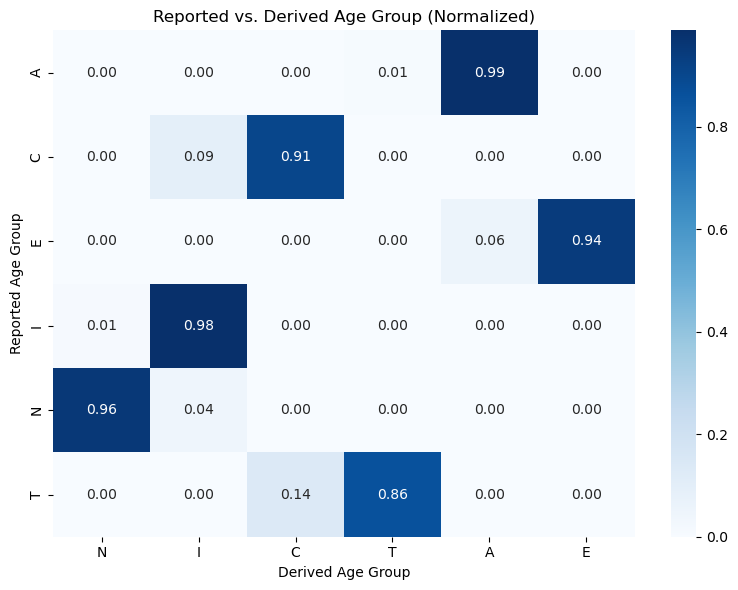

In [44]:
# ===================================================================
# 4. AGE GROUP CLASSIFICATION SYSTEM
# ===================================================================

def derive_age_group_with_teens(row):
    """
    Derive standardized age group from age and age_cod fields
    N = Neonate (0-27 days)
    I = Infant (28 days - 23 months) 
    C = Child (2-11 years)
    T = Teen (12-17 years)
    A = Adult (18-64 years)
    E = Elderly (65+ years)
    """
    if pd.isna(row['age']) or pd.isna(row['age_cod']):
        return None
    
    age = row['age']
    unit = row['age_cod']
    
    # Convert to years for classification
    if unit == 'DY':
        age_in_years = age / 365.25
    elif unit == 'WK':
        age_in_years = age / 52.18
    elif unit == 'MON':
        age_in_years = age / 12
    elif unit == 'YR':
        age_in_years = age
    elif unit == 'DEC':
        age_in_years = age * 10
    else:
        return None
    
    # Age group classification
    if age_in_years < (28/365.25):
        return 'N'  # Neonate
    elif age_in_years < 2:
        return 'I'  # Infant
    elif age_in_years < 12:
        return 'C'  # Child
    elif age_in_years < 18:
        return 'T'  # Teen
    elif age_in_years < 65:
        return 'A'  # Adult
    else:
        return 'E'  # Elderly

# Apply age group classification
# Create a mapping from age_cod to a multiplier (to convert to years)
unit_multipliers = {
    'DY': 1 / 365.25,
    'WK': 1 / 52.18,
    'MON': 1 / 12,
    'YR': 1,
    'DEC': 10
}

# Convert age_cod to uppercase just in case
demo_df['age_cod'] = demo_df['age_cod'].str.upper()

# Convert age to years
demo_df['age_in_years'] = demo_df['age'] * demo_df['age_cod'].map(unit_multipliers)

# Bin into derived age groups
age_bins = [-float('inf'), 28/365.25, 2, 12, 18, 65, float('inf')]
age_labels = ['N', 'I', 'C', 'T', 'A', 'E']

demo_df['derived_age_grp'] = pd.cut(demo_df['age_in_years'], bins=age_bins, labels=age_labels)

# Calculate classification accuracy
total_with_both = len(demo_df.dropna(subset=['age_grp', 'derived_age_grp']))
perfect_matches = (demo_df['age_grp'] == demo_df['derived_age_grp']).sum()
accuracy = perfect_matches / total_with_both * 100
recoverable = (demo_df['age_grp'].isna() & demo_df['derived_age_grp'].notna()).sum()

print(f"\n=== AGE GROUP CLASSIFICATION RESULTS ===")
print(f"Classification Accuracy: {accuracy:.1f}%")
print(f"Recoverable missing classifications: {recoverable:,}")

# Build a confusion matrix between reported and derived age groups
confusion_df = demo_df.dropna(subset=['age_grp', 'derived_age_grp'])

confusion_matrix = pd.crosstab(
    confusion_df['age_grp'],
    confusion_df['derived_age_grp'],
    rownames=['Reported Age Group'],
    colnames=['Derived Age Group'],
    normalize='index'  # Remove this if you want raw counts
)

print("\n=== AGE GROUP CONFUSION MATRIX ===")
print(confusion_matrix.round(2).to_string())

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, fmt=".2f", cmap='Blues')
plt.title("Reported vs. Derived Age Group (Normalized)")
plt.ylabel("Reported Age Group")
plt.xlabel("Derived Age Group")
plt.tight_layout()
plt.savefig("images/age_group_confusion_matrix.png", dpi=300)
plt.show()


=== PHARMACEUTICAL COMPLIANCE ANALYSIS ===
Top companies by missing demographic rates:
mfr_sndr
ZYDUS PHARM                         100.0
PUMA                                100.0
MSN LABORATORIES PRIVATE LIMITED    100.0
ORPHALAN                            100.0
PADAGIS                             100.0
BIOMARIN                            100.0
BIOLOGICAL E. LIMITED               100.0
PHARMING GROUP                      100.0
PHOTOCURE                           100.0
QUALGEN - NO LOCATION SPECIFIED     100.0
Name: count, dtype: float64

Companies with 100% missing demographics (over 1,000 reports):
ZYDUS PHARM: 1,112 reports (100% missing)
SK LIFE SCIENCE: 1,461 reports (100% missing)

Volume range for 100% non-compliant: 1112 - 1461 reports
Total reports from 100% non-compliant companies: 2,573

High-volume companies (Top 20 by report count) - Missing demographic rates:
mfr_sndr
ALEXION PHARMACEUTICALS    58.00
GLAXOSMITHKLINE            42.81
JOHNSON AND JOHNSON        22.10
AMGEN

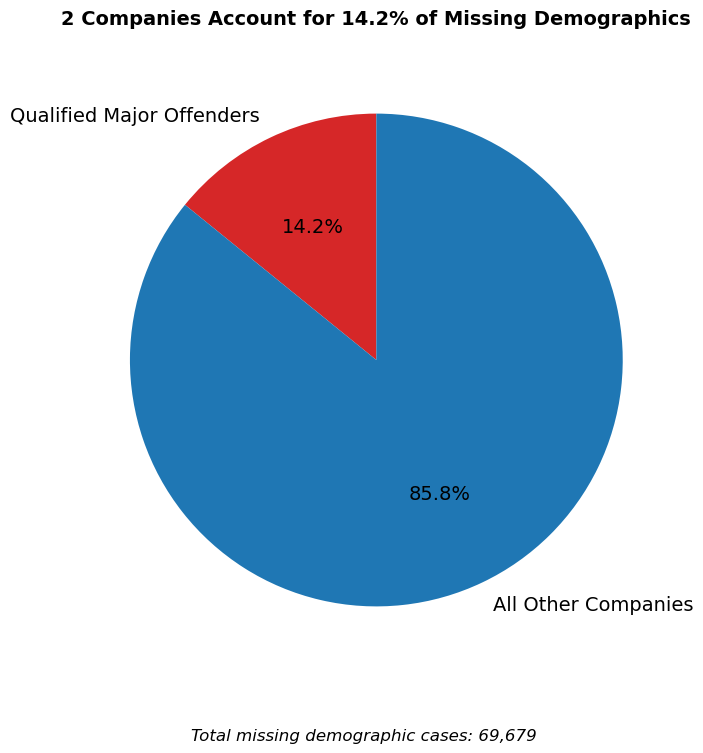

In [45]:
# ===================================================================
# 5. PHARMACEUTICAL COMPANY COMPLIANCE ANALYSIS
# ===================================================================

print("\n=== PHARMACEUTICAL COMPLIANCE ANALYSIS ===")

# Step 1: Calculate missing demographic rates by manufacturer
total_by_mfr = demo_df['mfr_sndr'].value_counts()
missing_by_mfr = all_missing_demo['mfr_sndr'].value_counts()
missing_rates = round(missing_by_mfr / total_by_mfr * 100, 2).sort_values(ascending=False)

print("Top companies by missing demographic rates:")
print(missing_rates.head(10))
print()

# Step 2: Identify companies with 100% missing demographics and >1,000 reports
perfect_non_compliant = missing_rates[missing_rates == 100.0]
perfect_non_compliant = perfect_non_compliant[
    perfect_non_compliant.index.to_series().map(
        lambda c: total_by_mfr.get(c, 0) > 1000
    )
]

print("Companies with 100% missing demographics (over 1,000 reports):")
for company in perfect_non_compliant.index:
    volume = total_by_mfr[company]
    print(f"{company}: {volume:,} reports (100% missing)")

volumes = [total_by_mfr[c] for c in perfect_non_compliant.index]
print(f"\nVolume range for 100% non-compliant: {min(volumes)} - {max(volumes)} reports")
print(f"Total reports from 100% non-compliant companies: {sum(volumes):,}")

# Step 3: High-volume companies (top 20) with missingness
high_volume_companies = total_by_mfr.head(20).index
high_volume_missing = missing_rates[missing_rates.index.isin(high_volume_companies)]

print(f"\nHigh-volume companies (Top 20 by report count) - Missing demographic rates:")
print(high_volume_missing.sort_values(ascending=False).head(10))

# Step 4: Define criteria for major offenders
MIN_REPORTS = 1000
MIN_MISSING_PCT = 30

offender_df = summary_df[
    (summary_df['Total Reports'] >= MIN_REPORTS) &
    (summary_df['Percent Missing'] >= MIN_MISSING_PCT)
].sort_values('Percent Missing', ascending=False)

major_offenders = offender_df.index.tolist()
offender_counts = offender_df['Missing All Demographics'].tolist()
offender_rates = offender_df['Percent Missing'].tolist()

# Recalculate total missing from these offenders
total_missing_from_offenders = all_missing_demo['mfr_sndr'].isin(major_offenders).sum()

# Step 5: Display details
print(f"\n=== MAJOR COMPLIANCE VIOLATIONS ===")
for company in major_offenders:
    company_total = summary_df.loc[company, 'Total Reports']
    company_missing = summary_df.loc[company, 'Missing All Demographics']
    missing_rate = summary_df.loc[company, 'Percent Missing']
    
    print(f"{company.upper()}:")
    print(f"  Total reports: {company_total:,}")
    print(f"  Missing demographics: {company_missing:,}")
    print(f"  Missing rate: {missing_rate:.2f}%")

print(f"\n{len(major_offenders)} companies account for {total_missing_from_offenders:,} of {len(all_missing_demo):,} missing cases")
print(f"That represents {total_missing_from_offenders/len(all_missing_demo)*100:.1f}% of the entire demographic data problem")

# Step 6: Print offender table
print("\n=== REVISED MAJOR OFFENDERS (BASED ON CRITERIA) ===")
print(offender_df.to_string())

# Step 7: Pie chart
labels = ['Qualified Major Offenders', 'All Other Companies']
# Step 1: Raw slice sizes
slice_counts = [
    total_missing_from_offenders,
    len(all_missing_demo) - total_missing_from_offenders
]

# Step 2: Percentages for display
sizes = [s / sum(slice_counts) * 100 for s in slice_counts]


fig, ax = plt.subplots(figsize=(10, 8))
wedges, texts, autotexts = ax.pie(sizes, labels=labels, autopct='%1.1f%%',
                                  colors=['#d62728', '#1f77b4'], startangle=90,
                                  textprops={'fontsize': 14})
ax.set_title(f"{len(major_offenders)} Companies Account for {sizes[0]:.1f}% of Missing Demographics",
             fontsize=14, fontweight='bold', pad=20)
plt.figtext(0.5, 0.02, f'Total missing demographic cases: {len(all_missing_demo):,}', 
            ha='center', fontsize=12, style='italic')
plt.savefig("images/revised_major_offenders_pie.png", dpi=300, bbox_inches='tight')
plt.show()


In [51]:
# ===================================================================
# 6. VERIFICATION AND FINAL SUMMARY
# ===================================================================

print("\n=== FINAL VERIFICATION ===")
print(f"Total FAERS 2025Q1 records analyzed: {len(demo_df):,}")
print(f"Records missing ALL demographics: {len(all_missing_demo):,} ({len(all_missing_demo)/len(demo_df)*100:.1f}%)")
print(f"Companies with >90% missing demographics: {len(missing_rates[missing_rates > 90])}")
print(f"Major offenders' contribution to problem: {total_missing_from_offenders/len(all_missing_demo)*100:.1f}%")

print(f"\n=== KEY FINDINGS SUMMARY ===")
pct_missing_all = len(all_missing_demo) / len(demo_df) * 100
print(f"1. {pct_missing_all:.1f}% of FDA adverse event reports lack basic patient demographics")

print(f"2. {len(major_offenders)} companies met high-risk threshold: >3,500 reports AND >50% missing demographics")
for name, rate in zip(major_offenders, offender_rates):
    count = offender_df.loc[name, 'Missing All Demographics']
    total = offender_df.loc[name, 'Total Reports']
    print(f"{name}: {rate:.2f}% non-compliant ({count:,}/{total:,} reports)")

print(f"5. This represents potential regulatory compliance violations affecting patient safety analysis")


print("The most compliant manufacturers (e.g., INTERCEPT PHARMACEUTICALS, BIOVITRUM) had <1% missing demographic data, while the worst offenders (e.g., ZYDUS PHARM, UROGEN PHARMA) submitted 100% of reports without key patient info.")
print(f"\nAnalysis complete. Data source: FDA FAERS 2025Q1")
print(f"Methodology: Standard data quality analysis of publicly available FDA database")



=== FINAL VERIFICATION ===
Total FAERS 2025Q1 records analyzed: 400,514
Records missing ALL demographics: 69,679 (17.4%)
Companies with >90% missing demographics: 68
Major offenders' contribution to problem: 14.2%

=== KEY FINDINGS SUMMARY ===
1. 17.4% of FDA adverse event reports lack basic patient demographics
2. 2 companies met high-risk threshold: >3,500 reports AND >50% missing demographics
ALEXION PHARMACEUTICALS: 58.00% non-compliant (7,148/12,324 reports)
GLAXOSMITHKLINE: 42.81% non-compliant (2,714/6,340 reports)
5. This represents potential regulatory compliance violations affecting patient safety analysis
The most compliant manufacturers (e.g., INTERCEPT PHARMACEUTICALS, BIOVITRUM) had <1% missing demographic data, while the worst offenders (e.g., ZYDUS PHARM, UROGEN PHARMA) submitted 100% of reports without key patient info.

Analysis complete. Data source: FDA FAERS 2025Q1
Methodology: Standard data quality analysis of publicly available FDA database
